In [ ]:
# Importing necessary libraries
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from surprise import accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import pickle
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import warnings


# Suppress warnings
warnings.filterwarnings('ignore')


In [2]:
# Load movies dataset
movies_df = pd.read_csv('movies.csv')
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load ratings dataset
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# Load links dataset (for extra movie information)
link_df = pd.read_csv('links.csv')
link_df.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Exploratory Data Analysis

In [43]:
n_ratings = len(ratings_df)
n_movies = len(movies_df)
n_users = ratings_df['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")


Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


### What is the distribution of movie ratings?

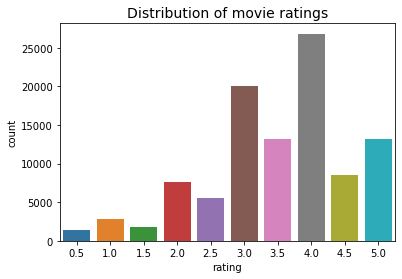

Mean global rating: 3.5.


In [47]:
sns.countplot(x='rating', data=ratings_df)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

print(f"Mean global rating: {round(ratings_df['rating'].mean(), 2)}.")


### Mean Rating Per User

In [49]:
mean_ratings = ratings_df.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}.")


Mean rating per user: 3.66.


### Which Movies are Most Frequently Rated?

In [52]:
movie_ratings = ratings_df.merge(movies_df, on='movieId')
top_movies = movie_ratings['title'].value_counts().head(10)
top_movies


Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

### What are the Lowest and Highest Rated Movies?

In [55]:
mean_ratings_movie = ratings_df.groupby('movieId')['rating'].mean()
lowest_rated = mean_ratings_movie.idxmin()
highest_rated = mean_ratings_movie.idxmax()

print(f"Lowest rated movie: {movies_df[movies_df['movieId'] == lowest_rated]['title'].values[0]}")
print(f"Highest rated movie: {movies_df[movies_df['movieId'] == highest_rated]['title'].values[0]}")


Lowest rated movie: Gypsy (1962)
Highest rated movie: Lamerica (1994)


## Bayesian Average

Bayesian Average is defined as:

$$
\text{Bayesian Average} = \frac{C \times m + R \times n}{n + m}
$$

Where:

- \( C \) represents our confidence,
- \( m \) represents our prior,
- \( n \) is the total number of reviews for movie \( i \),
- \( R \) is the average rating across all movies.


In [61]:
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [62]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [63]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

In [64]:
# apply bayesian_avg to all movies in our dataset.

bayesian_avg_ratings = ratings_df.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and Fight Club are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [65]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


### Exploring Movie Genres

To better analyze the genres and titles in the movie dataset, we need to perform some data cleaning. Specifically, the following tasks need to be addressed:

### 1. **Cleaning the 'genres' Column**

The `genres` column contains genre names as a single string, with genres separated by a pipe (`|`). For easier manipulation, we will split this column into a list of genres for each movie. This will allow for more efficient analysis of individual genres and their relationships to other attributes in the dataset.

### 2. **Extracting the Year from the 'title' Column**

The `title` column contains the year of release at the end of the movie title in parentheses. For better usability and to facilitate analysis based on year, we will extract the year from the title and store it in a new column called `year`. This will make it easier to work with the data when performing time-based analysis or sorting movies by release year.


In [66]:
# Split genres by pipe and store as a list
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split("|"))
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Analyzing the Number of Movie Genres
Let's now check how many unique genres exist in the dataset.

In [67]:
from collections import Counter

# Count the frequency of each genre
genre_frequency = Counter(g for genres in movies_df['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")
genre_frequency


There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

### Top 5 Most Common Genres

In [68]:
# Display the most common genres
print("The 5 most common genres: \n", genre_frequency.most_common(5))


The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


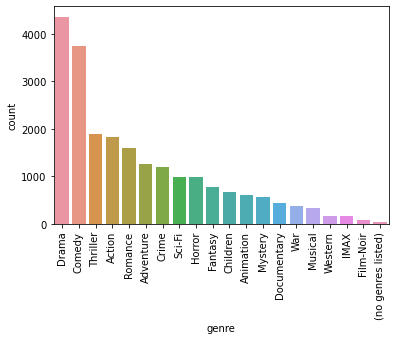

In [69]:
# Prepare the data for visualization
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

# Create a bar plot
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()


## Generating a Sparse User-Item Interaction Matrix

The `generate_user_item_matrix` function is designed to create a sparse matrix that represents the interactions between users and movies. This matrix is essential for building recommender systems, particularly collaborative filtering models.

The resulting matrix is in **Compressed Sparse Row (CSR)** format, which efficiently stores large sparse matrices by only keeping track of non-zero values. This is particularly useful when most of the matrix values are zeros, as it saves memory and computational resources.

The function also returns several mappings that make it easier to access user and movie information by their indices. These mappings are necessary for matrix-based operations in recommendation systems, allowing us to efficiently map user and movie IDs to their corresponding indices.

### Summary

The `generate_user_item_matrix()` function outputs a sparse matrix along with four mapper dictionaries:

- **`user_mapper`**: Maps user ID to user index.
- **`movie_mapper`**: Maps movie ID to movie index.
- **`user_inv_mapper`**: Maps user index to user ID.
- **`movie_inv_mapper`**: Maps movie index to movie ID.

These dictionaries are essential because they map which row/column of the utility matrix corresponds to which user or movie ID.

The user-item matrix itself is a `scipy.sparse.csr_matrix`, which stores the data in a sparse format, keeping memory usage efficient.


In [93]:
from scipy.sparse import csr_matrix

def generate_user_item_matrix(df):
    """
    Generates a sparse user-item interaction matrix (CSR Matrix) from the ratings dataframe.
    
    Args:
        df: A pandas DataFrame with columns: userId, movieId, rating
    
    Returns:
        - X: Sparse matrix (CSR format)
        - user_to_idx: Dictionary mapping user ids to user indices
        - movie_to_idx: Dictionary mapping movie ids to movie indices
        - idx_to_user: Dictionary mapping indices to user ids
        - idx_to_movie: Dictionary mapping indices to movie ids
    """
    # Check for missing columns
    required_columns = ['userId', 'movieId', 'rating']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {', '.join(required_columns)}")

    # Create mappings for user and movie indices
    user_to_idx = {user_id: idx for idx, user_id in enumerate(df['userId'].unique())}
    movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(df['movieId'].unique())}
    
    # Reverse mappings (index to id)
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

    # Map user/movie ids to indices
    user_indices = df['userId'].map(user_to_idx.get).values
    movie_indices = df['movieId'].map(movie_to_idx.get).values

    # Create the sparse matrix (CSR format)
    interaction_matrix = csr_matrix((df['rating'], (user_indices, movie_indices)),
                                    shape=(len(user_to_idx), len(movie_to_idx)))

    return interaction_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie


Create the User-Item Interaction Matrix

In [94]:
# Generate the user-item interaction matrix (CSR format) along with mappings
interaction_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie = generate_user_item_matrix(ratings_df)


Calculate and Evaluate Matrix Sparsity


In [95]:
# Calculate and print the sparsity of the user-item matrix
total_entries = interaction_matrix.shape[0] * interaction_matrix.shape[1]
rated_entries = interaction_matrix.nnz
sparsity_percentage = (rated_entries / total_entries) * 100
print(f"Matrix Sparsity: {sparsity_percentage:.2f}%")


Matrix Sparsity: 1.70%


### Evaluate Ratings Distribution per User and Movie

In [96]:
# Evaluate the number of ratings per user and movie
ratings_per_user = interaction_matrix.getnnz(axis=1)  # Number of ratings per user
ratings_per_movie = interaction_matrix.getnnz(axis=0)  # Number of ratings per movie

# Output the most/least active users and movies
print(f"Most active user rated {ratings_per_user.max()} movies.")
print(f"Least active user rated {ratings_per_user.min()} movies.")
print(f"Most rated movie has {ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {ratings_per_movie.min()} ratings.")


Most active user rated 2698 movies.
Least active user rated 20 movies.
Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


#### Distribution of Ratings per User and Movie

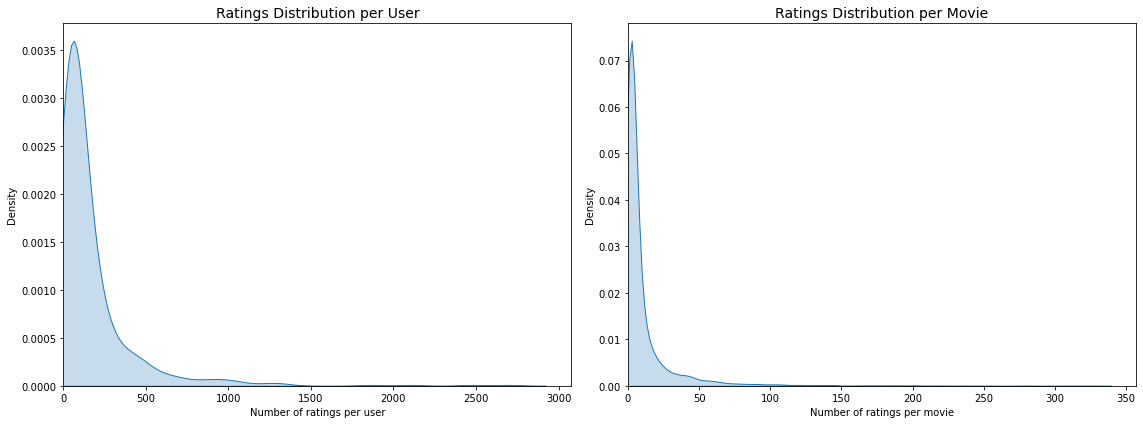

In [97]:
# Plot the distribution of ratings per user and per movie
plt.figure(figsize=(16, 6))

# Distribution of ratings per user
plt.subplot(1, 2, 1)
sns.kdeplot(ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Ratings Distribution per User", fontsize=14)
plt.xlabel("Number of ratings per user")
plt.ylabel("Density")

# Distribution of ratings per movie
plt.subplot(1, 2, 2)
sns.kdeplot(ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Ratings Distribution per Movie", fontsize=14)
plt.xlabel("Number of ratings per movie")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Item-item Recommendations with k-Nearest Neighbors

In this step, we will implement item-item recommendations using k-Nearest Neighbors (k-NN). This method recommends movies similar to one a user has interacted with, based on user engagement vectors.

### Process:
- **Input**: A function takes a `movie_id` and the `user-item matrix X`.
- **Similarity Calculation**: We use **cosine similarity** (but you can experiment with Euclidean or Manhattan distance).
- **Top k Similar Movies**: The function returns the top `k` most similar movies based on similarity scores.

This approach helps recommend movies that are similar to a user's previous ratings or interactions.


In [98]:
def find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='cosine'):
    """
    Finds k-nearest neighbors for a given movie based on user interactions.
    
    Args:
        movie_id: The ID of the movie of interest
        interaction_matrix: The user-item interaction matrix (CSR format)
        movie_to_idx: Dictionary mapping movie ids to indices
        idx_to_movie: Dictionary mapping indices to movie ids
        k: Number of similar movies to retrieve
        metric: Distance metric for kNN (default is 'cosine')
        
    Returns:
        List of k similar movie IDs
    """
    # Transpose the matrix to treat movies as rows (i.e., each row represents a movie)
    interaction_matrix = interaction_matrix.T
    
    # Get the index of the movie
    movie_idx = movie_to_idx[movie_id]
    
    # Get the vector of the movie
    movie_vector = interaction_matrix[movie_idx]
    
    # Reshape the movie vector for the kNN algorithm
    if isinstance(movie_vector, np.ndarray):
        movie_vector = movie_vector.reshape(1, -1)
    
    # Initialize the kNN model
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(interaction_matrix)
    
    # Find the k-nearest neighbors (excluding the movie itself)
    neighbors = kNN.kneighbors(movie_vector, return_distance=False)
    
    # Convert the indices of the nearest neighbors to movie IDs
    similar_movie_ids = [idx_to_movie[idx] for idx in neighbors[0][1:]]
    
    return similar_movie_ids


In [115]:

# Movie ID of interest (e.g., Toy Story)
from sklearn.neighbors import NearestNeighbors

movie_id = 1

# Find similar movies using k-NN (Cosine similarity)
similar_movie_ids = find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='cosine')

# Display the results
movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))

print(f"Because you watched {movie_titles[movie_id]} You may also Like:")
for similar_movie_id in similar_movie_ids:
    print(f"- {movie_titles[similar_movie_id]}")


Because you watched Toy Story (1995) You may also Like:
- Toy Story 2 (1999)
- Jurassic Park (1993)
- Independence Day (a.k.a. ID4) (1996)
- Star Wars: Episode IV - A New Hope (1977)
- Forrest Gump (1994)
- Lion King, The (1994)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Mission: Impossible (1996)
- Groundhog Day (1993)
- Back to the Future (1985)


####  Experiment with Different Metrics

In [117]:
# Experiment with 'euclidean' or 'manhattan' distance
similar_movie_ids_euclidean = find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='euclidean')

print(f"\nBecause you watched {movie_titles[movie_id]} You may also like (Euclidean):")
for similar_movie_id in similar_movie_ids_euclidean:
    print(f"- {movie_titles[similar_movie_id]}")



Because you watched Toy Story (1995) You may also like (Euclidean):
- Toy Story 2 (1999)
- Mission: Impossible (1996)
- Independence Day (a.k.a. ID4) (1996)
- Bug's Life, A (1998)
- Nutty Professor, The (1996)
- Willy Wonka & the Chocolate Factory (1971)
- Babe (1995)
- Groundhog Day (1993)
- Mask, The (1994)
- Honey, I Shrunk the Kids (1989)


In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommendations(user_id, recommended_movie_ids, ground_truth_movie_ids, all_movie_ids):
    """
    Evaluate the recommendation system using precision, recall, and F1 score.
    
    Args:
        user_id (int): The user for whom the recommendations are evaluated.
        recommended_movie_ids (list): List of recommended movie IDs.
        ground_truth_movie_ids (list): List of ground truth movie IDs (i.e., movies the user has actually watched).
        all_movie_ids (list): List of all possible movie IDs in the system.
    
    Returns:
        precision (float): Precision score.
        recall (float): Recall score.
        f1 (float): F1 score.
    """
    # Create binary vectors for recommended and ground truth movies
    recommended_binary = [1 if movie_id in recommended_movie_ids else 0 for movie_id in all_movie_ids]
    ground_truth_binary = [1 if movie_id in ground_truth_movie_ids else 0 for movie_id in all_movie_ids]
    
    # Compute precision, recall, and F1 score
    precision = precision_score(ground_truth_binary, recommended_binary)
    recall = recall_score(ground_truth_binary, recommended_binary)
    f1 = f1_score(ground_truth_binary, recommended_binary)
    
    return precision, recall, f1


In [107]:
# Example of actual ground truth for a given user (movies they actually interacted with)
ground_truth_movie_ids = [1, 2, 3, 4]  # Replace with actual ground truth for the user

# Example of recommended movies (usually obtained from your recommendation system)
recommended_movie_ids = [1, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Replace with the output from your recommender

# All movie IDs in your dataset
all_movie_ids = list(range(1, 9743))  # Replace with the actual list of all movie IDs (from your dataset)

# Evaluate the recommendations
precision, recall, f1 = evaluate_recommendations(user_id=1, 
                                                 recommended_movie_ids=recommended_movie_ids,
                                                 ground_truth_movie_ids=ground_truth_movie_ids,
                                                 all_movie_ids=all_movie_ids)

# Print evaluation results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.1
Recall: 0.25
F1 Score: 0.14285714285714288


### Model Performance Evaluation

### Precision: 0.1
Precision measures the proportion of recommended items that are relevant. A value of 0.1 means only 10% of recommendations were relevant, indicating low accuracy.

### Recall: 0.25
Recall measures the proportion of relevant items that were recommended. A value of 0.25 means 25% of relevant items were recommended, which is still low.

### F1 Score: 0.14
The F1 score is the harmonic mean of precision and recall. A value of 0.14 suggests the model is underperforming, with both precision and recall being low.

### Possible Reasons for Low Scores:
- **Cold-start problem**: Insufficient training or data may lead to poor recommendations.
- **Lack of relevant interactions**: Low overlap between user interests and recommendations.
- **Limited diversity**: Highly biased recommendations may hurt both precision and recall.
- **Sparse data**: Insufficient user-item interactions in collaborative filtering can lead to poor performance.


### Handling the Cold-Start Problem

In [108]:
# Convert the Genres Column into Binary Features
n_movies = movies_df['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

# Extract unique genres from the dataset
genres = set(g for G in movies_df['genres'] for g in G)

# Add a binary column for each genre
for g in genres:
    movies_df[g] = movies_df.genres.transform(lambda x: int(g in x))

# Create a new DataFrame with binary genre features
movie_genres = movies_df.drop(columns=['movieId', 'title', 'genres'])

# Display the first few rows
movie_genres.head()


There are 9742 unique movies in our movies dataset.


,Film-Noir,Horror,Comedy,Crime,Documentary,Adventure,Romance,War,Mystery,IMAX,Drama,Animation,Fantasy,(no genres listed),Sci-Fi,Thriller,Action,Western,Children,Musical
0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
# Compute the Cosine Similarity Matrix for Movie Genres
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between movies based on genre features
cosine_sim = cosine_similarity(movie_genres, movie_genres)

# Print the shape of the cosine similarity matrix
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")


Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [120]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies_df['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0] 

# Example usage
title = movie_finder('toy stor')
print(title)  # 'Jumanji (1995)'


Toy Story (1995)


### Generate Recommendations for Similar Movies(Fuzzywuzzy)

In [112]:
movie_idx = dict(zip(movies_df['title'], list(movies_df.index)))
idx = movie_idx['Jumanji (1995)']
n_recommendations = 10

sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations + 1)]

similar_movies = [i[0] for i in sim_scores]
print(f"Because you watched {title}:")
print(movies_df['title'].iloc[similar_movies])


Because you watched Jumanji (1995):
53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object


### Function to Get Content-Based Recommendations

In [122]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations + 1)]
    similar_movies = [i[0] for i in sim_scores]
    
    print(f"Because you watched {title}:")
    print(movies_df['title'].iloc[similar_movies])

# Example usage
get_content_based_recommendations('Honey, I Shrunk the Kids', 10)


Because you watched Honey, I Shrunk the Kids (1989):
478                              Super Mario Bros. (1993)
559                                      Space Jam (1996)
8806                                          Home (2015)
9169           Wizards of Waverly Place: The Movie (2009)
1357                                Borrowers, The (1997)
2233                                  Time Bandits (1981)
3629                    Bill & Ted's Bogus Journey (1991)
5122                       *batteries not included (1987)
5517    Ewok Adventure, The (a.k.a. Caravan of Courage...
5523                   Ewoks: The Battle for Endor (1985)
Name: title, dtype: object


In [5]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Splitting the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)


In [6]:
# Instantiate SVD algorithm
SVD_algor = SVD()

# Train the SVD model
SVD_algor.fit(trainset)

# Make predictions for the test set
predictions = SVD_algor.test(testset)

# Evaluate the model
svd_rmse = accuracy.rmse(predictions)
print(f"SVD RMSE: {svd_rmse}")


RMSE: 0.8804
SVD RMSE: 0.8803617326302614


### KNN Basic Algorithm


In [7]:
# Instantiate KNN algorithm (user-based collaborative filtering)
KNN_algor = KNNBasic(sim_options={'user_based': True})

# Train the KNN model
KNN_algor.fit(trainset)

# Make predictions for the test set
predictions = KNN_algor.test(testset)

# Evaluate the model
knn_rmse = accuracy.rmse(predictions)
print(f"KNN RMSE: {knn_rmse}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9536
KNN RMSE: 0.9536473611319315


### Model Comparison


In [8]:
# Store RMSE results for both models
results = {
    "SVD": [svd_rmse],
    "KNN": [knn_rmse]
}

# Convert the dictionary to a DataFrame for easier comparison
results_df = pd.DataFrame(results).T
results_df = results_df.rename(columns={0: "RMSE"})
results_df.sort_values(by='RMSE', ascending=True)


,RMSE
SVD,0.880362
KNN,0.953647


In [9]:
# Save the KNN model to a file
file_name = 'knn_model.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(KNN_algor, file)


### Web Scraping for Movie Metadata (Images and URLs)

In [ ]:
# Create empty columns with null values
link_df['url'] = np.nan
link_df['img_url'] = np.nan


for idx, tmdbId in tqdm(enumerate(link_df['tmdbId']), total = len(link_df['tmdbId'])):
    try:
        # Get url
        url = 'https://www.themoviedb.org/movie/' + str(tmdbId)
        link_df['url'][idx] = url

        # assign the response to a object
        response = requests.get(url)

        # Use BeautifulSoup() to create a BeautifulSoup object from a response text content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find image container
        obj = soup.find('div', 'image_content backdrop').img

        # Get image url
        image_url = 'https://www.themoviedb.org' + obj.get('data-src')

        # Link image url
        link_df['img_url'][idx] = image_url
    except AttributeError:
        image_url = 'https://www.firstcolonyfoundation.org/wp-content/uploads/2022/01/no-photo-available.jpeg'
        
        link_df['img_url'][idx] = image_url

  0%|          | 0/9742 [00:00<?, ?it/s]

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


100%|██████████| 9742/9742 [1:10:47<00:00,  2.29it/s]


### Save the Scrapped Data

In [18]:
# Save the scraped metadata (URLs and Image URLs)
link_df.to_csv('link_df.csv', index=False)


In [38]:
links_df = pd.read_csv('links_df.csv')

In [39]:
links_df

,movieId,imdbId,tmdbId,url,img_url
0,1,114709,862.0,https://www.themoviedb.org/movie/862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
1,2,113497,8844.0,https://www.themoviedb.org/movie/8844.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
2,3,113228,15602.0,https://www.themoviedb.org/movie/15602.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
3,4,114885,31357.0,https://www.themoviedb.org/movie/31357.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
4,5,113041,11862.0,https://www.themoviedb.org/movie/11862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
...,...,...,...,...,...
9737,193581,5476944,432131.0,https://www.themoviedb.org/movie/432131.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9738,193583,5914996,445030.0,https://www.themoviedb.org/movie/445030.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9739,193585,6397426,479308.0,https://www.themoviedb.org/movie/479308.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9740,193587,8391976,483455.0,https://www.themoviedb.org/movie/483455.0,https://www.themoviedb.org/t/p/w300_and_h450_b...


In [40]:
# Checking unique values for img_url and url columns
unique_img_urls = link_df['img_url'].unique()
unique_urls = link_df['url'].unique()

# Display the unique values
print("Unique img_url values:")
print(unique_img_urls)

print("\nUnique url values:")
print(unique_urls)


Unique img_url values:
['https://www.themoviedb.org/t/p/w300_and_h450_bestv2/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg'
 'https://www.themoviedb.org/t/p/w300_and_h450_bestv2/6aGn2X51bahFoOI8wE1h2VGTgcH.jpg'
 'https://www.themoviedb.org/t/p/w300_and_h450_bestv2/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg'
 ...
 'https://www.themoviedb.org/t/p/w300_and_h450_bestv2/iPzkjNWpK7ud5pE997eGaB4QhaG.jpg'
 'https://www.themoviedb.org/t/p/w300_and_h450_bestv2/7ueB7Kxq2GObp5aDw6rsdzVefzP.jpg'
 'https://www.themoviedb.org/t/p/w300_and_h450_bestv2/isX74cYvlYVDyyiZKyDAfzz2Wkg.jpg']

Unique url values:
['https://www.themoviedb.org/movie/862.0'
 'https://www.themoviedb.org/movie/8844.0'
 'https://www.themoviedb.org/movie/15602.0' ...
 'https://www.themoviedb.org/movie/479308.0'
 'https://www.themoviedb.org/movie/483455.0'
 'https://www.themoviedb.org/movie/37891.0']


### Prepare data for recomemdation


In [41]:
# Merge movies data with links (scraped metadata)
merged_df = pd.merge(movies_df, link_df, on='movieId')
merged_df.head()


,movieId,title,genres,imdbId,tmdbId,url,img_url
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,https://www.themoviedb.org/movie/862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,https://www.themoviedb.org/movie/8844.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,https://www.themoviedb.org/movie/15602.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,https://www.themoviedb.org/movie/31357.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,https://www.themoviedb.org/movie/11862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...


### Load the Best Model (KNN)

In [12]:
# Load the saved KNN model
file_name = 'knn_model.pkl'
with open(file_name, 'rb') as file:
    loaded_model = pickle.load(file)


### Make Movie Recommendations for a Specific User

In [22]:
user_id = 2  # Example: User with ID 2

# Get the list of movies already rated by the user
user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

# Get the list of unrated movies
unrated_movies = merged_df[~merged_df['movieId'].isin(user_movies)]

# Get top-10 movie recommendations for the user
k = 10
user_recommendations = loaded_model.get_neighbors(user_id, k=k)

# Get the recommended movies from the unrated list
recommended_movies = unrated_movies[unrated_movies['movieId'].isin(user_recommendations)]
recommended_movies


,movieId,title,genres,imdbId,tmdbId,url,img_url
21,22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller,112722,1710.0,None,https://www.firstcolonyfoundation.org/wp-conte...
225,261,Little Women (1994),Drama,110367,9587.0,None,https://www.firstcolonyfoundation.org/wp-conte...
244,282,Nell (1994),Drama,110638,1945.0,None,https://www.firstcolonyfoundation.org/wp-conte...
346,389,"Colonel Chabert, Le (1994)",Drama|Romance|War,109454,41580.0,None,https://www.firstcolonyfoundation.org/wp-conte...
429,492,Manhattan Murder Mystery (1993),Comedy|Mystery,107507,10440.0,None,https://www.firstcolonyfoundation.org/wp-conte...
496,574,Spanking the Monkey (1994),Comedy|Drama,111252,17600.0,None,https://www.firstcolonyfoundation.org/wp-conte...
497,575,"Little Rascals, The (1994)",Children|Comedy,110366,10897.0,None,https://www.firstcolonyfoundation.org/wp-conte...
508,590,Dances with Wolves (1990),Adventure|Drama|Western,99348,581.0,None,https://www.firstcolonyfoundation.org/wp-conte...


### Display Recommendations

In [114]:
# Display the recommended movies with their metadata (title, genres, image URL, and movie URL)
recommended_movies[['movieId', 'title', 'genres', 'url', 'img_url']]


,movieId,title,genres,url,img_url
21,22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller,None,https://www.firstcolonyfoundation.org/wp-conte...
225,261,Little Women (1994),Drama,None,https://www.firstcolonyfoundation.org/wp-conte...
244,282,Nell (1994),Drama,None,https://www.firstcolonyfoundation.org/wp-conte...
346,389,"Colonel Chabert, Le (1994)",Drama|Romance|War,None,https://www.firstcolonyfoundation.org/wp-conte...
429,492,Manhattan Murder Mystery (1993),Comedy|Mystery,None,https://www.firstcolonyfoundation.org/wp-conte...
496,574,Spanking the Monkey (1994),Comedy|Drama,None,https://www.firstcolonyfoundation.org/wp-conte...
497,575,"Little Rascals, The (1994)",Children|Comedy,None,https://www.firstcolonyfoundation.org/wp-conte...
508,590,Dances with Wolves (1990),Adventure|Drama|Western,None,https://www.firstcolonyfoundation.org/wp-conte...
